<a href="https://colab.research.google.com/github/LucioFassarella/COMQ/blob/main/ComQ_Problema_CorteMaximo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema do Corte Máximo:

Resolução pela estratégia QAOA

## Instalação de pacotes e métodos

In [2]:
'''
Instalação do Qiskit e pacotes de visualização
'''
!pip install qiskit -U
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

import qiskit
qiskit.__version__

!pip install matplotlib
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currentl

In [3]:
'''
Pacotes e Métodos
'''

# NumPy e SciPy
import numpy as np
import scipy as sp

# Minimizador do SciPy
from scipy.optimize import minimize

# Métodos do Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.circuit.library import QAOAAnsatz

# Estimadores do Qiskit
from qiskit_aer.primitives import Estimator # <-- Estimator para simulação clássica
# from qiskit_ibm_runtime import EstimatorV2 as Estimator # <-- Estimator para computação quântica
# from qiskit_ibm_runtime import SamplerV2 as Sampler # <-- Estimator para computação quântica

# Qiskit Runtime
#from qiskit_ibm_runtime import QiskitRuntimeService, Session

import time

## Definição de métodos específicos

In [4]:
def Hamiltoniano_Corte(n = 'int', w = 'list'):
    '''
    Função que contrói o Hamiltoniano de corte para um grafo.

    Entradas:
        n: número de qubits (int)
        w: matriz de pesos (list)

    Saída:
        HC: Hamiltoniano do corte (SparsePauliOp)

    Método requerido:
        from qiskit.quantum_info import SparsePauliOp

    '''

    '''
    ### Verificação da consistência dos dados de entrada
    '''

    if type(n) != int:
        return print("O primeiro argumento deve ser um inteiro")
    if type(w) != list:
        return print("O segundo argumento deve ser uma lista quadrada simétrica")
    if n != len(w):
        return print("O comprimento da l ista deve ser igual ao primeiro argumento")

    '''
    ### Código principal
    '''

    operadores = []

    peso_total = 0
    for j in range(n):
        for i in range(j):
            peso_total += w[i][j]

    operadores.append(("I",[0], peso_total/2))

    for j in range(n):
        for i in range(j):
            operadores.append(("ZZ",[i,j], -w[i][j]/2))

    HC = SparsePauliOp.from_sparse_list(operadores, num_qubits = n)

    return HC

In [5]:
def Operador_Separador(n = 'int', w = 'list', g = 'float'):
    '''
    Função que contrói o operador separador da estratégia QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        w : matriz de pesos (list)
        g: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(n) != int:
        return print("O primeiro argumento deve ser um inteiro")
    if type(w) != list:
        return print("O segundo argumento deve ser uma lista quadrada simétrica")
    if n != len(w):
        return print("O comprimento da lista deve ser igual ao primeiro argumento")

    '''
    Código principal
    '''

    qc = QuantumCircuit(n, name = "H_P")

    for j in range(n):
        for i in range(j):
            qc.rzz(g*w[i][j],i,j)

    return qc

In [6]:
def Operador_Misturador(n = 'int', b = 'float'):
    '''
    Função que contrói o operador misturador da estratégia QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        g: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(n) != int:
        return print("O primeiro argumento deve ser um inteiro")

    '''
    Código principal
    '''

    qc = QuantumCircuit(n, name = "H_M")

    for i in range(n):
            qc.rx(b,i)

    return qc

In [7]:
def QAOA_Ansatz(n = 'int', w = 'list', p = 'int', g_vec = 'list', b_vec = 'list'):
    '''
    Função que contrói o circuito quântico QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        w : matriz de pesos (list)
        g_vec: lista de parâmetros reais (float)
        b_vec: lista de parâmetros reais (float)

    Saída:
        qc: circuito quântico parametrizado com n qubits.

    Métodos requeridos:
        Hamiltoniano_Corte
        Operador_Separador
        Operador_Misturador

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''
    if type(n) != int:
        return print("O primeiro argumento 'n' deve ser um inteiro.")
    if type(w) != list:
        return print("O segundo argumento 'w' deve ser uma lista quadrada simétrica.")
    if n != len(w):
        return print("O comprimento da lista 'w' deve ser igual ao primeiro argumento 'n'.")
    if type(p) != int:
        return print("O terceiro argumento 'p' deve ser um inteiro.")
    if type(g_vec) != list:
        return print("O quarto argumento 'g_vec' deve ser uma lista de floats.")
    if type(b_vec) != list:
        return print("O quinto argumento 'b_vec' deve ser uma lista de floats.")
    if len(g_vec) != p or len(b_vec) != p:
        return print("Os parâmetros 'g_vec' e 'b_vec' devem ter comprimento igual ao terceiro argumento 'p'.")
    # if circuito_preparacao != None:
    #     if type(circuito_preparacao) != QuantumCircuit:
    #         return print("O sexto argumento 'circuito_preparacao' pode ser omitido ou deve ser um circuito quântico com tantos qubits quanto o primeiro argumento 'n'.")

    '''
    Código principal
    '''

    # Construção do circuito
    qc = QuantumCircuit(n, name = "QAOA_Ansatz")

    for i in range(n):
        qc.h(i)

    qubits = range(n)
    for i in range(p):
        qc.append(Operador_Separador(n, w, g_vec[i]), qubits)
        qc.append(Operador_Misturador(n, b_vec[i]), qubits)

    return qc

In [8]:
def CorteQ(parametros = 'list', n = 'int', w = 'list', p = 'int', estimator = 'qiskit_aer.primitives'):
    '''
    Função que retorna o corte de uma partição do grafo

    Entradas:
        estimator: estimador quântico (Estimator)
        n: número de qubits (int)
        w: matriz de pesos (list)
        p: profundidade do ansatz QAOA (int)
        parametros: 'g_vec + b_vec' = lista de parâmetros combinando parâmetros de separação e  parâmetros de mistura

    Saída:
        cost = float: custo

    Métodos requeridos:
        QAOA_Ansatz
        Estimator
        pass_manager: Qiskit PassManager

    Observações:
        Para executar esta função, é necessário previamente definir o "estimator"
        e inicializar o transpilador pelo comando
        "pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)"
    '''
    # Construção do circuito QAOA
    g_vec = list(parametros[:p])
    b_vec = list(parametros[p:])
    QAOA = QAOA_Ansatz(n, w, p, g_vec, b_vec)

    # Cálculo do corte
    QAOA_transpilado = pass_manager.run(QAOA)
    HC = Hamiltoniano_Corte(n, w)
    HC_transpilado = HC.apply_layout(QAOA_transpilado.layout)
    job = estimator.run([(QAOA_transpilado, HC_transpilado)])
    corte = job.result()[0].data.evs

    return corte

In [51]:
'''
Funções auxiliares para pós-processamento

(Elas definem representações de inteiros em base arbitrária e vice-versa)
'''

# Função que calcula o corte de uma partição de um grafo
def Corte(w,A):
    '''
    Função que calcula o corte de uma partição de um grafo

    Entradas:
        w: matriz de pesos (list)
        A: lista de vértices da partição

    Saída:
        corte: corte da partição (float)
    '''

    n = len(w)
    corte = 0
    for i in range(n):
        for j in range(i):
            if (i in A and j not in A) or (j in A and i not in A):
                corte += w[i][j]

    return corte

# Função que retorna o estado da base computacional mais proeminente de um estado gerado por um circuito quântico
def estado_base_max(qc, num_qubits):
    '''
    Determina o estado da base computacional que tem maior probabilidade no estado
     gerado por um circuito quântico 'qc' num registro quântico com 'num_qubits' qubits.

    Entradas:
        qc (QuantumCircuit): circuito quântico
        num_qubits (int): número de qubits do circuito

    Saída:
        string: o estado da base com maior probabilidade, na forma de string binária

    Métodos:
        qiskit.QuantumCircuit
        qiskit.quantum_info.Statevector
        numpy as np
    '''

    estado = Statevector.from_instruction(qc)
    probabilidades = estado.probabilities()
    estado_base_maximo = np.argmax(probabilidades)
    return format(estado_base_maximo, f'0{num_qubits}b')

# Função que retorna a lista de comprimento 'l' com os dígitos na base 'b' de um inteiro 'x' dado na base 10
def numero_para_digitos(x,b,l):
    '''
    Função que retorna a lista de dígitos do inteiro 'x'  na base 'b'
    com comprimento 'l' (no mínimo) e na ordem anti-lexicográfica

    Entradas:
        b : inteiro positivo : base
        x : inteiro a ser apresentado na base 'b'
        l : inteiro positivo : comprimento da representação

    Saída:
        list : lista de inteiros positivos
    '''
    if x < 0:
        sign = -1
    else:
        sign = 1

    x *= sign

    ordem = 0
    while x >= b**ordem:
        ordem += 1

    ordem = max(ordem,l)

    repres = [0 for k in range(ordem)]

    for k in range(ordem):
        expoente = ordem - k - 1
        repres[k] = x // b**expoente
        x = x % b**expoente

    return np.array(repres)

# Função que retorna o número escrito na base 10 para dada lista 'lista' com seus dígitos na base 'b'
def digitos_para_numero(lista,b):
    '''
    Função que apresenta na base '10' um inteiro dado pela lista 'lista'
    de seus dígitos na base 'b' na ordem anti-lexicográfica

    Entradas:
        b : inteiro positivo : base
        x : inteiro a ser apresentado na base 'b'

    Saída:
        int : 'x' na base '10'
    '''
    ordem = len(lista)
    n = 0
    for k in range(0,ordem):
        n = n + lista[k]*(5**(ordem - k - 1))
    return n

## Exemplos

### Exemplo 1: Grafo com 5 vértices

Dimensão do grafo: 5
Matriz de pesos:


[[0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0]]

Grafo:


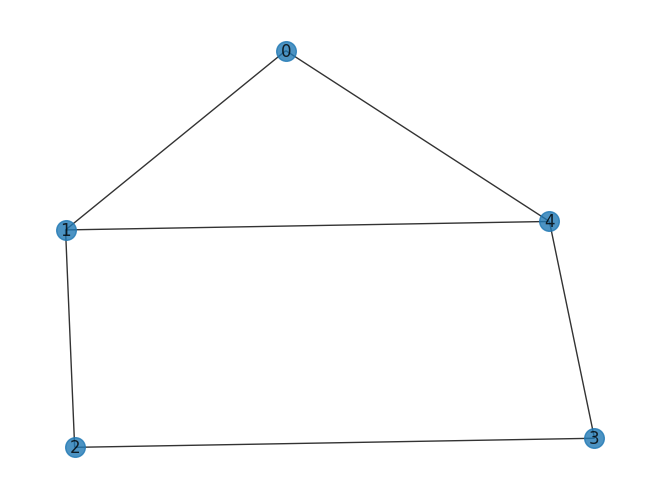

In [53]:
'''
Grafo
'''

n = 5
print(f"Dimensão do grafo: {n}")

w = [
   [0,1,0,0,1],
   [1,0,1,0,1],
   [0,1,0,1,0],
   [0,0,1,0,1],
    [1,1,0,1,0]
]
print("Matriz de pesos:")
display(w)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(n)
G.add_nodes_from(vertices)

arestas = []
for i in range(n):
    for j in range(n):
        if w[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [60]:
'''
Resolução clássica
'''
# Uma partição e seu corte

A = [1,3]
B = []
for k in range(len(w)):
    if k not in A:
        B.append(k)
print(f"Partição: {(A,B)}")
corte = Corte(w,A)
print(f"Corte da partição: {corte}")

Partição: ([1, 3], [0, 2, 4])
Corte da partição: 5


In [54]:
'''
Métodos para execução da estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [57]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, n, w, p, estimator):
    valor = CorteQ(parametros, n, w, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (n, w, p, estimator), tol = 1/2**12, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [1.4363067983312678, 1.0980542301375351, 5.177453422950592, 1.18984763165332, 0.7051843261946449, 0.9941273356722612, 1.0661154166702311, 4.668654098949084]
Parâmetros finais: [ 2.88506888  2.63013645  5.9145214   0.59957911 -0.04056422  1.49162857
  0.61357717  5.16999813]
Corte: 4.601568663808061
Tempo de execução: 1.5378252188364665 minutos


In [58]:
'''
Pós-processamento
'''

g_vec = list(parametros_max[:p])
b_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(n, w, p, g_vec, b_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,n)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(n):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(w,A)}. Partição de corte máximo: {(A,B)}")

Estado de corte máximo: 01010
Corte Máximo: 5. Partição de corte máximo: ([1, 3], [0, 2, 4])


### Exemplo 2: Grafo com 14 vértices e pesos variáveis

Dimensão do grafo: 14
Matriz de pesos:


[[0.0, 0.36, 0.47, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.36, 0.0, 0.0, 0.0, 0.16, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.47, 0.0, 0.0, 0.37, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14, 0.0, 0.37, 0.0, 0.0, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.16, 0.0, 0.0, 0.0],
 [0.0, 0.69, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.19, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.66, 0.0, 0.0, 0.0, 0.52],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, 0.66, 0.0, 0.0, 0.43, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.15],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.76, 0.0, 0.43, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19, 0.0, 0.0, 0.76, 0.0, 0.0, 0.38],
 [0.0, 0.0, 0.0,

Grafo:


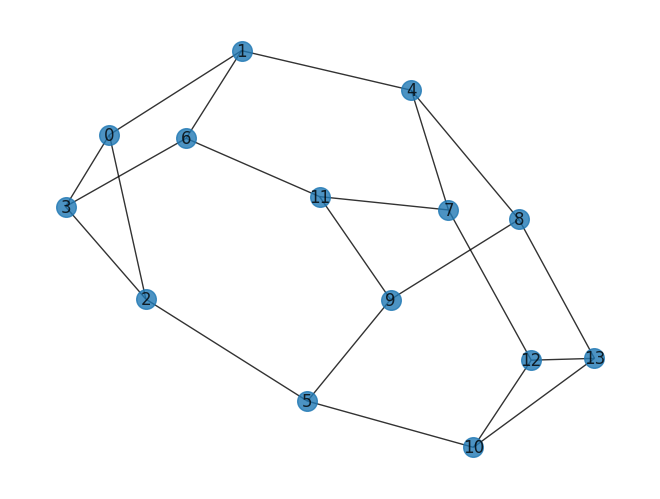

In [61]:
'''
Grafo
'''

n = 14
print(f"Dimensão do grafo: {n}")

w = [
   [0.00,0.36,0.47,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.36,0.00,0.00,0.00,0.16,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.47,0.00,0.00,0.37,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.14,0.00,0.37,0.00,0.00,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.82,0.70,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.16,0.00,0.00,0.00],
   [0.00,0.69,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.19,0.00],
   [0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.52],
   [0.00,0.00,0.00,0.00,0.00,0.90,0.00,0.00,0.66,0.00,0.00,0.43,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.15],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.76,0.00,0.43,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.76,0.00,0.00,0.38],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.15,0.00,0.38,0.00]
]
print("Matriz de pesos:")
display(w)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(n)
G.add_nodes_from(vertices)

arestas = []
for i in range(n):
    for j in range(n):
        if w[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [62]:
'''
Resolução clássica
'''

# Uma partição e seu corte

A = [0,5,6,7,8,12]
B = []
for k in range(len(w)):
    if k not in A:
        B.append(k)
print(f"Partição: {(A,B)}")
corte = Corte(w,A)
print(f"Corte da partição: {corte}")

Partição: ([0, 5, 6, 7, 8, 12], [1, 2, 3, 4, 9, 10, 11, 13])
Corte da partição: 9.53


In [63]:
'''
Métodos para implementar estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [ ]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 5
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, n, w, p, estimator):
    valor = CorteQ(parametros, n, w, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
num_iteracoes = 3
for k in range(num_iteracoes):
    parametros = parametros_iniciais
    estimator = Estimator()
    corte = minimize(neg_CorteQ, parametros, args = (n, w, p, estimator), tol = 1/2**12, method="COBYLA")
    parametros = corte.x
    corte_max = - corte.fun #Troca de sinal
    print(f"Iteração: {k+1}")
    print(f"Parâmetros finais: {parametros}")
    print(f"Corte: {corte_max}")
parametros_max = parametros

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 5 (tipo: <class 'int'>
Parâmetros iniciais: [4.375626321119913, 2.0584174978969267, 1.2605611380510213, 2.863745419161834, 5.605427782466016, 0.0469452316476046, 0.7508340299627962, 4.965376133327138, 4.622729276493296, 5.7654120315977435]


In [71]:
'''
Pós-processamento
'''

g_vec = list(parametros_max[:p])
b_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(n, w, p, g_vec, b_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,n)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(n):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(w,A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 00101111001100
Corte Máximo: 5.580000000000001. Partição de corte máximo: ([2, 4, 5, 6, 7, 10, 11], [0, 1, 3, 8, 9, 12, 13])
